In [1]:
#%%
#            Chem 210A  begun 2017  Prof. McCurdy
#
"""  Template for calculating a potential curve 
        using psi4 as a python module
  
    Starting point for Chem 210A problems -- CWM November 1, 2017
    Modifications January 5 2020 and notes on guesses for UHF and HF
    calculations

    This starter script is set up to do Unrestricted Hartree Fock (UHF)
    calculation. That calculation breaks spin symmetry for internuclear
    distances greater than the Coulson-Fisher point, but gives the ordinary
    restricted Hartree-Fock solution for shorter internuclear distances

    Two changes do the Restricted Hartree Fock (RHF) calculation instead
   
    Minor changes allow MP2 and CISD calculations on this and other diatomics
    With suitable modifications this template can be used to calculate a bond 
    stretching curve for one bond in a polyatomic molecule.
      
"""

'  Template for calculating a potential curve \n        using psi4 as a python module\n  \n    Starting point for Chem 210A problems -- CWM November 1, 2017\n    Modifications January 5 2020 and notes on guesses for UHF and HF\n    calculations\n\n    This starter script is set up to do Unrestricted Hartree Fock (UHF)\n    calculation. That calculation breaks spin symmetry for internuclear\n    distances greater than the Coulson-Fisher point, but gives the ordinary\n    restricted Hartree-Fock solution for shorter internuclear distances\n\n    Two changes do the Restricted Hartree Fock (RHF) calculation instead\n   \n    Minor changes allow MP2 and CISD calculations on this and other diatomics\n    With suitable modifications this template can be used to calculate a bond \n    stretching curve for one bond in a polyatomic molecule.\n      \n'

In [2]:
#%%
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
import re as re   #  regular expression library -- used to modify the geometry object by replacing 
                  #  a symbol with a number
import numpy as np # numpy library for square roots etc.in gemometry and unit manipulations
psi4.set_memory('2048 MB')           # minimum memory should be 1 GB. Generally  2GB or greater is better
filestring = 'aug-cc-pvQZ_output_diatomic.txt'   # file for complete output from Psi4 -- overwritten if it exists. 
psi4.core.set_output_file(filestring,False) 
#filestring_plot = 'potcurve.dat'      # file for output of potential curve for plotting - see below.
from datascience import*                                  # overwritten if it exists.
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fast')
import os     # operating system commands for manipulating files
print("testing")
print("psi4 output is directed to ",filestring,"\n")
#

testing
psi4 output is directed to  aug-cc-pvQZ_output_diatomic.txt 



In [3]:
#%%
#                    SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the loop on distances.
#
# NOTE to use UHF guess_mix true option, we must use c1 symmetry
# (no symmetry) just as we must when doing geometry optimizations 
#
# Specifying cartesian coordinates in this example, type of atom
# and its charge are specified by the chemical symbol
# first line is charge and spin multiplicity 1 = singlet 
# 3 = triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF and necessary for UHF
# For linear molecules try c2v symmetry, which should be faster and
# will label orbital energies with symmetries in this point group

In [4]:
# 1.73 to R_value
# H to F
h2_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      F  0.0 0.0 1.73
    units bohr
    symmetry c1 """

#   print the geometry 
print(h2_geometry)
#
#  parameters for the curve
#


      0 1 
      H  0.0 0.0 0.0 
      F  0.0 0.0 1.73
    units bohr
    symmetry c1 


In [5]:

#
N_Rvals = 61  # when debugging use a small number of R values
Rmin = 1.0
Rmax = 10.0
dr = (Rmax-Rmin)/(N_Rvals-1)
#
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  but for UHF larger basis sets sometimes harder to converge to 
#  spin symmetry broken result. Options given here work for double zeta and 
#  triple zeta correlation consistent basis sets for H2)
#
psi4.set_options({'basis': 'aug-cc-pvQZ'}) 
#                        METHOD OR REFERENCE METHOD 
#   Method, and/or  reference for CI or MP2 calculations is set here
psi4.set_options({"reference": "rhf"})  # change "uhf" to "rhf" for restricted HF
#
#                          SCF INITIAL GUESS
#  initial guess options for SCF, very important for UHF and sometimes ROHF
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#
#   guess_mix gives a guess that mixes alpha and beta spin orbitals to allow 
#   UHF to find the spin broken solution(s) 
psi4.set_options({"guess_mix": 'true'})
#
#   guess: core good for closed shell restricted Hartree-Fock 
#   should replace guess:  sad below for restricted Hartree-Fock 
#psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian  guess
#
#  some other guess options that help converge UHF calculations 
psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
psi4.set_options({"SOSCF": 'true'})   #  second order scf is quadratically convergent algorithm
psi4.set_options({"MAXITER": 500})  

In [6]:
Rvals=[]
Calculated_Energies=[]
#
#%%
# LOOP over R values 
#
for n in range(N_Rvals):
    R = Rmin + n*dr
#
    psi4.set_options({'guess': 'read'})  #  can be used to follow a solution as R changes
#                                     #  if we put an if statement here to use this option
#                                     #  for n > 0, after first starting orbitals are defined
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object h2_geometry
# to make a new object h2_geo_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    h2_geo_R = re.sub("R_value",str(R),h2_geometry)
#
#    print(h2_geo_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf rohf uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
    finalenergy=psi4.energy('scf',molecule=psi4.geometry(h2_geo_R) )
    print("R = ",R,"   psi4.energy   ", finalenergy)
    Rvals.append(R)
    Calculated_Energies.append(finalenergy)
#
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#

R =  1.0    psi4.energy    -100.06862706351703
R =  1.15    psi4.energy    -100.06862706351684
R =  1.3    psi4.energy    -100.06862706351686
R =  1.45    psi4.energy    -100.0686270635168
R =  1.6    psi4.energy    -100.06862706351681
R =  1.75    psi4.energy    -100.06862706351677
R =  1.9    psi4.energy    -100.06862706351697
R =  2.05    psi4.energy    -100.06862706351696
R =  2.2    psi4.energy    -100.06862706351698
R =  2.3499999999999996    psi4.energy    -100.068627063517
R =  2.5    psi4.energy    -100.06862706351696
R =  2.65    psi4.energy    -100.06862706351683
R =  2.8    psi4.energy    -100.068627063517
R =  2.95    psi4.energy    -100.06862706351697
R =  3.1    psi4.energy    -100.06862706351694
R =  3.25    psi4.energy    -100.06862706351704
R =  3.4    psi4.energy    -100.06862706351684
R =  3.55    psi4.energy    -100.06862706351683
R =  3.6999999999999997    psi4.energy    -100.06862706351677
R =  3.85    psi4.energy    -100.06862706351694
R =  4.0    psi4.energy   

In [40]:
100.0195-99.573-0.0203

0.42620000000000036

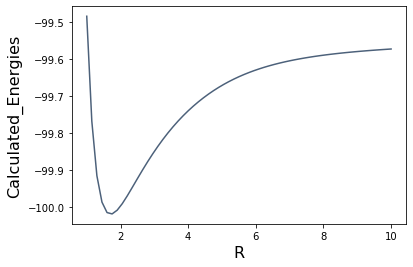

In [114]:
Table_of_energies = Table().with_columns("R",Rvals,"Calculated_Energies", Calculated_Energies)
Table_of_energies.plot(0)

In [115]:
rmin = Table_of_energies.sort("Calculated_Energies").show(1)
rmin

R,Calculated_Energies
1.75,-100.019


In [76]:
R

10.0

In [ ]:
f = open(filestring_plot,'w')  # rename this file for the case at hand
for n in range(N_Rvals):
    print(Rvals[n],"   ",Calculated_Energies[n])
    print(Rvals[n],"   ",Calculated_Energies[n],file=f)
#
#%%
#
#  MAKE PLOTS FROM THE OUTPUT FILE OR PUT PLOTTING COMMANDS HERE
#  FOR A PROPERLY LABELED GRAPH 
#  plotting with xmgrace or other plotting code is recommended, and easier than plotting
#  several cases from this python script.  However, by doing several cases and saving the 
#  data in arrays, all plots can be made using python in a self contained script built on
#  this starter.
#
exit()